# 1주차

linear, Tree model로 접근해보기

In [ ]:
# 기본 library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import random

# 모델 library
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor 


In [ ]:
train = pd.read_csv("/content/drive/My Drive/Dacon_튜터/train_features.csv")
test = pd.read_csv("/content/drive/My Drive/Dacon_튜터/test_features.csv")
y_train = pd.read_csv("/content/drive/My Drive/Dacon_튜터/train_target.csv", index_col=0)
y_test = pd.read_csv("/content/drive/My Drive/Dacon_튜터/sample_submission.csv", index_col=0)

df = train.append(test)

feature의 생김새 파악

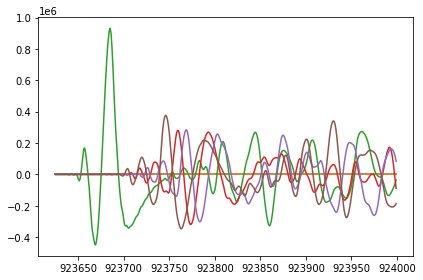

In [ ]:
n = random.randint(0, df['id'].max())
temp = df[df['id'] == n]

plt.plot(temp)
plt.tight_layout()

feature의 경우 S1, S2, S3, S4가 존재하고 각각은 실험판 위, 각각 다른 곳에 위치하고 있다.\
각각의 센서 (S1, S2, S3, S4)가 대략 어느 좌표에 가까이 위치하고 있는지 찾아보자

In [ ]:


def 센서별_도착시간계산(Data_input):
    Data = Data_input.copy()

    각센서별도착시간_pd = []
    for idx in tqdm(pd.Series(Data['id'].unique()).sort_values().values):
        temp = Data[Data['id'] == idx][['S1', 'S2', 'S3', 'S4']]
        temp = temp.reset_index(drop=True)

        각센서별도착시간 = [temp[temp[col] != 0].index.min() for col in temp.columns]
        각센서별도착시간_pd.append(각센서별도착시간)
    
    return(pd.DataFrame(각센서별도착시간_pd, columns=['S1','S2','S3','S4']))

In [ ]:
도착시간 = 센서별_도착시간계산(df)

100%|██████████| 3500/3500 [00:21<00:00, 165.57it/s]


센서값과 target X, Y 관계 파악하기

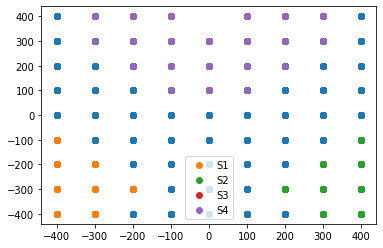

In [ ]:
# 샘플별로 S1센서에 제일 먼저 파동이 도착한 경우, S2가 먼저 도착한경우, S3이 먼저 도착한경우, S4가 먼저 도착한 경우를 판단하자
# S1에 1,2,3,4안에 도착한 샘플의 X,Y좌표를 본다. 
# S2에 1,2,3,4안에 도착한 샘플의 X,Y좌표를 본다. 
# S3에 1,2,3,4안에 도착한 샘플의 X,Y좌표를 본다. 
# S4에 1,2,3,4안에 도착한 샘플의 X,Y좌표를 본다. 


plt.scatter(y_train['X'], y_train['Y'])


for col in 도착시간.columns:
    idx = 도착시간[도착시간[col].isin([1,2,3,4])].index
    temp = y_train[y_train.index.isin(idx)]
    plt.scatter(temp['X'], temp['Y'], label=col)
    plt.legend()

# S3의 경우 먼저 도착한 샘플이 없다. S3은 해당 판 위에 존재하지 않음을 알 수 있다.

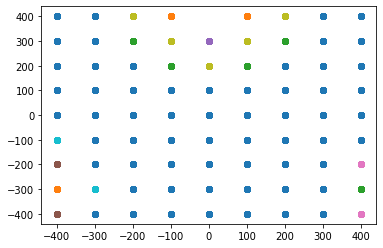

In [ ]:
# 1초에 도착한경우, 2초에 도착한경우, 3초에 도착한 경우별로 나누어 봤을 때 센서의 도착시간을 통해 좌표를 어느정도 유추할 수 있음을 알 수 있다. 

plt.scatter(y_train['X'], y_train['Y'])

for i in range(1, 4):
    for col in 도착시간.columns:
        idx = 도착시간[도착시간[col] == i].index
        temp = y_train[y_train.index.isin(idx)]
        plt.scatter(temp['X'], temp['Y'])

즉, 우리는 각 센서의 도착시간을 통해 어느정도 X,Y 좌표를 짐작할 수 있음을 알 수 있다\
그렇다면, M, V와 센서값은 어떤 관계를 가지고 있을까? \
하지만, 1주차에서 말했듯이 진동파는 에너지이기 때문에 시간이 지남에 따라 그 강도가 약해질 수 밖에 없다. 이를 한번 확인해보자

그 전에, 샘플별로 (375, 6) 형태의 shape으로 존재하고 있는 데이터를 (1, 375*4) 형태로 변형한다 (Time, id 의경우는 제외한다)\


In [ ]:
def transform_data(Data_input):
    Data = Data_input.copy()

    frame = Data.copy()
    frame['Time'] = (frame['Time']*1000000)/4
    frame = frame.loc[:,['Time','S1','id']].copy()
    # 1D로 바꾸기 위해 unstack을 해줍니다.
    frame = frame.set_index(['id','Time']).unstack()
    # 그리고, col을 Time과 짝지어줍니다.
    frame.columns = frame.columns.map(lambda x: '{}_{}'.format(x[0], int(x[1])))

    for col in ['S2','S3','S4']:
        temp = Data.copy()
        temp['Time'] = (temp['Time']*1000000)/4
        temp = temp.loc[:,['Time',col,'id']].copy()
        temp = temp.set_index(['id','Time']).unstack()
        temp.columns = temp.columns.map(lambda x: '{}_{}'.format(x[0], int(x[1])))
        frame = pd.concat([frame, temp], axis=1)

    return frame

In [ ]:
df_tf = transform_data(df)

앞서 각 센서별 도착시간을 구했는데, 각 샘플별로 가장 먼저 도착한 센서만을 뽑아서 확인하자. 앞서 말햇듯이 센서가 뒤늦게 도착할 수록, 반사파가 포함되게 되어 깨끗한 통계량을 뽑을 수 없다.

In [ ]:
먼저도착센서_List = [도착시간.columns[도착시간.iloc[i,:].argmin()] for i in 도착시간.index]

In [ ]:
frame = pd.DataFrame(np.array(df_tf.iloc[0,0:375]))
for i in tqdm(range(0, len(먼저도착센서_List))):
    idx = df_tf.columns.str.find(먼저도착센서_List[i]) == 0
    frame = pd.concat([frame, pd.DataFrame(np.array(df_tf.loc[i,idx]))], axis=1)

frame = frame.iloc[:,1:].T
frame.index = df_tf.index
frame.columns = ['{}_{}'.format('S', i) for i in range(0, 375)]

100%|██████████| 3500/3500 [00:29<00:00, 118.10it/s]


# 이제 각 샘플별로 센서들의 도착시간과, 제일 처음 도착한 센서로 구성된 DataFrame 생성 완료!
(참고로 한 샘플에서 도착시간이 같으면 센서값이 같습니다)

In [ ]:
도착시간['first_sensor'] = [도착시간.columns[도착시간.iloc[i,0:4].astype("int").argmin()] for i in range(0, len(도착시간))]
도착시간['last_sensor'] = [도착시간.columns[도착시간.iloc[i,0:4].astype("int").argmax()] for i in range(0, len(도착시간))]
도착시간['min_time'] = 도착시간.iloc[:,0:4].min(axis=1)

도착시간 = pd.concat([도착시간, pd.get_dummies(도착시간[['first_sensor', 'last_sensor']])], axis=1)
도착시간.drop(['last_sensor','first_sensor'], axis=1, inplace=True)
도착시간.head()

,S1,S2,S3,S4,min_time,first_sensor_S1,first_sensor_S2,first_sensor_S4,last_sensor_S1,last_sensor_S2,last_sensor_S3
0,10,10,28,22,10,1,0,0,0,0,1
1,27,5,18,14,5,0,1,0,1,0,0
2,4,22,22,17,4,1,0,0,0,1,0
3,19,8,18,12,8,0,1,0,1,0,0
4,5,23,20,14,5,1,0,0,0,1,0


In [ ]:
frame.index.name = None
frame.head()

,S_0,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,S_10,S_11,S_12,S_13,S_14,S_15,S_16,S_17,S_18,S_19,S_20,S_21,S_22,S_23,S_24,S_25,S_26,S_27,S_28,S_29,S_30,S_31,S_32,S_33,S_34,S_35,S_36,S_37,S_38,S_39,...,S_335,S_336,S_337,S_338,S_339,S_340,S_341,S_342,S_343,S_344,S_345,S_346,S_347,S_348,S_349,S_350,S_351,S_352,S_353,S_354,S_355,S_356,S_357,S_358,S_359,S_360,S_361,S_362,S_363,S_364,S_365,S_366,S_367,S_368,S_369,S_370,S_371,S_372,S_373,S_374
0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,-4.972607e-08,-0.000001,-0.000008,-0.000067,-0.000369,-0.001590,-0.004151,-0.003038,0.044299,0.270403,1.057531,3.079798,6.975893,13.26630,20.67299,28.86184,34.46991,28.20700,-17.24963,-113.5247,-191.3353,-122.5786,147.424,325.8574,79.08008,-463.9099,-601.4113,217.4622,1179.707,688.046,...,-1401.46,-28967.88,-59182.80,-91707.63,-119384.60,-141669.70,-151852.500,-148561.10,-130807.90,-100789.20,-63468.21,-22974.74,18381.29,52831.72,85755.28,110769.80,130597.20,139896.80,139618.600,129680.00,111627.60,89429.27,65070.58,43737.440,26563.69,13962.09,3199.015,-8663.771,-21120.04,-35067.27,-46126.97,-54675.60,-59357.98,-62021.77,-63401.59,-64168.90,-64236.79,-63755.9500,-63020.44,-61808.07
1,0.0,0.0,0.0,0.0,0.000000,-4.104924e-07,-0.000021,-0.003461,-4.406150e-02,-0.911897,-5.669239e+00,-24.789780,-60.042590,-11.207930,325.865600,892.124800,789.762900,-1133.037000,-3170.929000,-1296.596000,4873.333000,6775.193000,-3438.976000,-13753.97000,-4966.18300,13210.55000,15362.07000,14.56343,-18139.34000,-25793.5100,-14313.4600,7271.5070,23513.800,36671.8900,75824.82000,133441.2000,158374.7000,83145.8800,-86450.830,-300760.600,...,-105441.50,-133208.30,-148219.60,-151475.10,-128492.80,-67915.02,26531.830,143567.40,253712.70,347682.30,416188.30,458415.40,468928.70,441024.90,375555.20,291047.90,190375.40,95710.05,-1090.979,-89265.75,-176409.30,-249748.70,-309234.80,-348319.200,-372610.40,-383885.20,-380013.600,-353028.600,-301423.30,-221216.30,-131079.50,-27611.32,69232.23,166839.20,249213.60,318184.50,354831.00,354107.2000,310828.90,230333.60
2,0.0,0.0,0.0,0.0,-0.000092,-6.843146e-03,-0.155149,-3.675771,-2.513809e+01,-99.968380,-1.874429e+02,126.648400,1067.813000,1165.781000,-1203.031000,-3605.582000,-1432.085000,4507.028000,5000.117000,-1202.514000,-4422.679000,-2002.576000,523.418500,-32.09178,-8347.37000,-25719.01000,-36065.61000,-22117.23000,19586.62000,75466.5300,128675.2000,162016.6000,150729.000,93604.6100,10285.94000,-72428.1400,-162611.2000,-238985.8000,-308847.900,-355592.000,...,-12232.84,-42017.52,-56430.98,-57612.15,-45939.64,-23683.38,4542.572,36435.54,64287.75,83535.06,88255.77,77599.51,52408.50,21051.76,-15252.53,-44828.87,-67639.99,-77141.91,-75941.730,-66382.88,-51200.52,-33900.47,-15142.43,1782.044,15104.45,21444.32,19715.040,9991.861,-3751.06,-20315.34,-34635.28,-47002.69,-53314.07,-53257.75,-46299.88,-33790.75,-18243.53,589.0179,21578.07,44502.97
3,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,-1.783159e-07,-0.000239,-3.049932e-03,-0.057637,-0.362194,-1.434991,-2.560133,4.565285,35.041880,88.969460,83.658250,-79.151250,-257.599000,-61.196180,532.386400,568.25670,-720.05600,-1733.57200,-197.59590,2284.22800,1979.61300,-954.1006,-3047.4710,-2058.5410,1562.411,4040.5380,2727.77400,-1738.3270,-4117.0680,-795.0732,1298.735,-3950.966,...,-31559.38,-32735.39,-31596.70,-31604.31,-35510.13,-43694.69,-54905.540,-68935.60,-84166.34,-99962.02,-114080.70,-125093.30,-131730.60,-132532.10,-128839.60,-122459.00,-114082.40,-105618.70,-97187.990,-92312.43,-92761.21,-100317.60,-114365.90,-131810.500,-150164.20,-165730.30,-177100.800,-184156.000,-187168.60,-188668.70,-189887.60,-191973.00,-194712.70,-197321.10,-197018.70,-191734.60,-180159.30,-162329.7000,-140439.60,-114594.30
4,0.0,0.0,0.0,0.0,0.000000,3.230998e-07,0.000015,-0.000178,-1.208969e-02,-0.629234,-5.395420e+00,-25.978690,-51.962140,56.209530,401.361700,490.147800,-388.874100,-1634.919000,-617.491000,2516.028000,2481.577000,-1861.890000,-4094.611000,-1197.22800,2928.

In [ ]:
최초도착센서 = frame.copy()

앞서 말했던, 시간에 따라 에너지가 감소함을 확인해보자. 즉, 이를통해 시간이라는 변수가 어떤식으로든 활용되어야 함을 알 수 있다.\
(M, V가 도착시간에 따라 동일하게 분포되어있기에 도착시간이 늦어짐에 따라서 진폭의 전반적인 scale이 감소되고 있다)

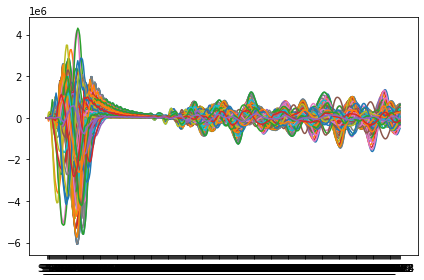

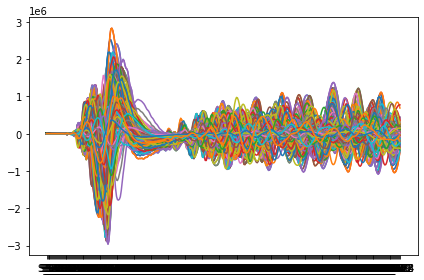

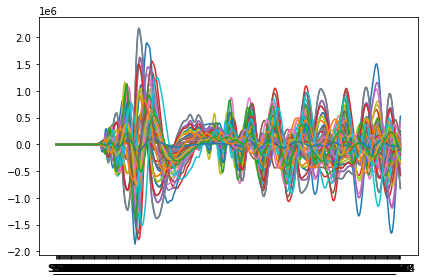

In [ ]:
for i in [1, 5, 10]:
    idx = 도착시간[도착시간[['S1','S2','S3','S4']].min(axis=1) == i].index
    plt.figure()
    plt.plot(최초도착센서.loc[idx,:].T)
    plt.tight_layout()
    plt.show()

센서값과 M,V가 어떻게 관련되어있는지도 확인해보자!
V는 센서값의 기울기와 깊은 관려이 있고, M은 정규화한 이후의 기울기와 깊은 관련이 있습니다.(5정도의 시간간격을 가지고 기울기를 계산한다)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

In [ ]:
def subtract_each_col(df, stride):
    temp = df.copy()
    for i in range(stride, len(temp.columns)):
        temp[temp.columns[i-stride] + "-" + temp.columns[i]] = temp[temp.columns[i-stride]]-temp[temp.columns[i]]
        
    return temp.iloc[:,len(df.columns):]

In [ ]:
std_scaler.fit(최초도착센서.T)
최초도착센서_scaled = std_scaler.transform(최초도착센서.T).T
최초도착센서_scaled = pd.DataFrame(최초도착센서_scaled)
최초도착센서_scaled.columns = 최초도착센서.columns

In [ ]:
기울기 = subtract_each_col(최초도착센서, 5)
기울기_scaled = subtract_each_col(최초도착센서_scaled, 5)

이제, 구한 기울기와 target간에 상관관계를 봅니다
최초 도착시간에 따라 나누지 않아도, 어느정도의 상관관계를 보이긴합니다.

In [ ]:
기울기_차 = 기울기.max(axis=1) - 기울기.min(axis=1)
corr = np.corrcoef(기울기_차[기울기_차.index < 2800], y_train['V'])[0][1]
print(corr)

0.8701488178742588


하지만, 최초도착시간에 따라 나누어 본다면, 더 확실한 상관관계를 갖습니다.

Text(0.5, 1.0, 'V_mean_correlation_0.9749341193162591')

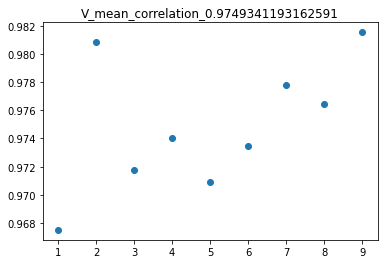

In [ ]:
corr = []
for time in range(1, 10):

    idx = 도착시간[도착시간['min_time'] == time].index
    idx = idx[idx < 2800]
    기울기_차 = 기울기.max(axis=1) - 기울기.min(axis=1)
    corr.append(np.corrcoef(기울기_차[idx], y_train['V'][idx])[0][1])        

plt.scatter(range(1,10), corr)
plt.title("V_mean_correlation_" + str(np.array(corr).mean()))

이것은 M도 마찬가지입니다.하지만
M의 경우는 정규화한 센서와 관계가 있기 때문에, 다소 시간에 따른 영향을 받지 않습니다.

In [ ]:
기울기_차 = 기울기_scaled.max(axis=1) - 기울기_scaled.min(axis=1)
corr = np.corrcoef(기울기_차[기울기_차.index < 2800], y_train['M'])[0][1]
print(corr)

-0.7771939067023996


Text(0.5, 1.0, 'M_mean_correlation_-0.8059713134949942')

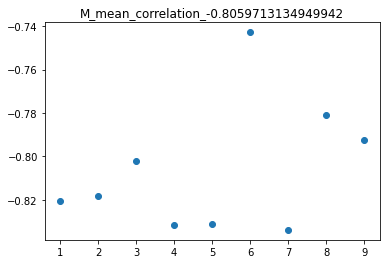

In [ ]:
corr = []
for time in range(1, 10):

    idx = 도착시간[도착시간['min_time'] == time].index
    idx = idx[idx < 2800]
    기울기_차 = 기울기_scaled.max(axis=1) - 기울기_scaled.min(axis=1)
    corr.append(np.corrcoef(기울기_차[idx], y_train['M'][idx])[0][1])        

plt.scatter(range(1,10), corr)
plt.title("M_mean_correlation_" + str(np.array(corr).mean()))

# 이제 샘플별 최초 도착 센서와 도착시간을 가지고 다양한 통계량들을 만들면서 데이터를 파악해봅시다!

In [ ]:
도착시간_save = 도착시간.copy()
df_tf_save = df_tf.copy()

이제, 각 센서별 도착시간오에 최초 도착센서를 가지고 다양한 통계량을 추출합니다.

In [ ]:
df_MV = 도착시간.copy()

In [ ]:
df_MV['first_signal_slope_max'] = 기울기.max(axis=1)
df_MV['first_signal_abs_slope_max'] = abs(기울기).max(axis=1)
df_MV['first_signal_slope_max-min'] = 기울기.max(axis=1) - 기울기.min(axis=1)
df_MV['first_signal_slope_var'] = 기울기.var(axis=1)

In [ ]:
df_MV['first_stdsignal_slope_max-min'] = 기울기_scaled.max(axis=1) - 기울기_scaled.min(axis=1)
df_MV['first_stdsignal_slope_max'] = 기울기_scaled.max(axis=1)
df_MV['first_stdsignal_slope_abs_max'] = abs(기울기_scaled).max(axis=1)
df_MV['first_stdsignal_slope_var'] = 기울기_scaled.var(axis=1)
df_MV['first_stdsignal_slope_abs_mean'] = abs(기울기_scaled).mean(axis=1)

In [ ]:
df_MV['first_signal_max'] = 최초도착센서.max(axis=1)
df_MV['first_signal_abs_max'] = abs(최초도착센서).max(axis=1)
df_MV['first_signal_var'] = 최초도착센서.var(axis=1)

만든 통계량들에서 N제곱변수들을 만듭니다.

In [ ]:
df_MV_temp = df_MV[df_MV.columns[df_MV.columns.str.find('first') == 0]].copy()

In [ ]:
df_MV_temp2 = df_MV_temp.copy()
for num in [2, 3, 4, 5, 1/2, 1/3, 1/4, 1/5]:
    temp = df_MV_temp**(num)
    temp.columns = df_MV_temp.columns + "_" + str(num)
    df_MV_temp2 = pd.concat([df_MV_temp2, temp], axis=1)

In [ ]:
df_MV = pd.concat([df_MV, df_MV_temp2], axis=1)

모델 학습을 진행합니다.

In [ ]:
def E22(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    
    
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))

def E11(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

In [ ]:
y_test = pd.read_csv("/content/drive/My Drive/Dacon_튜터/sample_submission.csv", index_col=0)

In [ ]:
y_val_save = y_train.copy()
y_val_save.iloc[:,:] = 0

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GroupKFold

num_fold=5
score = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    t1 = df_MV[df_MV['min_time'] == T]
    t1 = t1.drop(['min_time'], axis=1)

    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[X_train_temp.index]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        #model = RandomForestRegressor(n_jobs=-1, random_state=777, n_estimators=1000, max_features=0.7)
        clf = linear_model.Lasso(alpha=0, random_state=777)
        clf.fit(trn_x, trn_y['V'])
        y_pred = clf.predict(val_x)
        #print(abs(val_y['V'] - y_pred).mean())
        score.append(abs(val_y['V'] - y_pred).mean())
        y_test.loc[X_test_temp.index,'V'] += clf.predict(X_test_temp)/num_fold
        y_val_save.loc[val_x.index,'V'] = y_pred
#print(E22(val_y, y_pred))

In [ ]:
print(np.array(score).mean())
V_value = y_val_save['V'].append(y_test['V'])

0.005040035198602148


M을 학습시켜봅시다!

In [ ]:
score = []
wow = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    
    최초도착센서_abs_cumsum = abs(최초도착센서).cumsum(axis=1)
    index = df_MV[(df_MV['min_time'] == Time)].index
    index = index[index<2800]
    max_corr = []
    for col in 최초도착센서_abs_cumsum.columns:
        max_corr.append(np.corrcoef(최초도착센서_abs_cumsum.loc[index][col]/y_train.loc[index,'V'], y_train.loc[index,'M'])[0][1])
    
    
    wow.append(np.array(max_corr)[~np.isnan(np.array(max_corr))].max())
    
    
    max_corr = [0 if x != x else x for x in max_corr]
    col = 최초도착센서.columns[np.array(max_corr).argmax()]
    
    t1 = df_MV[df_MV['min_time'] == T]
    t1 = t1.drop(['min_time'], axis=1)
    index = t1.index
    for num in [1, 1/2, 2, 1/3, 3, 1/4, 4]:
        magic_col = 최초도착센서_abs_cumsum.loc[index, col]/V_value.loc[index]**(num)
        for num2 in [1, 1/2, 2]:
            t1["magic_col" + str(num) + "_" + str(num2)] = magic_col**(num2)
            
    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[X_train_temp.index]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        clf = linear_model.Lasso(alpha=0, random_state=777)
        clf.fit(trn_x, trn_y['M'])
        y_pred = clf.predict(val_x)
        #print(abs(val_y['V'] - y_pred).mean())
        score.append(abs(val_y['M'] - y_pred).mean())
        y_test.loc[X_test_temp.index,'M'] += clf.predict(X_test_temp)/num_fold
        y_val_save.loc[val_x.index,'M'] = y_pred

In [ ]:
np.array(score).mean()

1.825675008107517

In [ ]:
y_val_save['M'] = np.clip(y_val_save['M'], 25, 175)
y_val_save['V'] = np.clip(y_val_save['V'], 0.2, 1)

In [ ]:
E22(y_train, y_val_save)*0.5

0.0006545855028720749

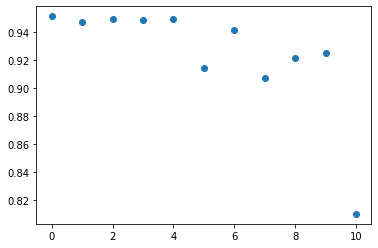

In [ ]:
plt.scatter(range(0,11),wow)

In [ ]:
y_test['M'] = np.clip(y_test['M'], 25, 175)
y_test['V'] = np.clip(y_test['V'], 0.2, 1)

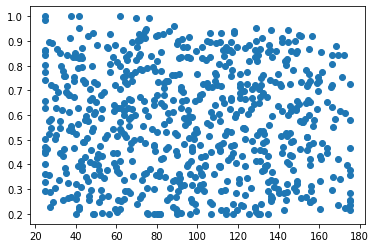

In [ ]:
plt.scatter(y_test['M'], y_test['V'])

X,Y예측

In [ ]:
def subtract_each_col(Data_input):
    temp = Data_input.copy()
    temp2 = temp.copy()
    for i in range(0, len(temp2.columns)-1):
        for j in range(i+1, len(temp2.columns)):
            temp[temp.columns[i] + "-" + temp.columns[j]] = temp2.iloc[:,i] - temp2.iloc[:,j]
    
    return temp.iloc[:,len(temp2.columns):]

def plus_each_col(Data_input):
    temp = Data_input.copy()
    temp5 = temp.copy()
    for i in range(0, len(temp5.columns)-1):
        for j in range(i+1, len(temp5.columns)):
            temp[temp.columns[i] + "+" + temp.columns[j]] = temp5.iloc[:,i] + temp5.iloc[:,j]
            
    return temp.iloc[:,len(temp5.columns):]

In [ ]:
df_XY = 도착시간.iloc[:,0:4].copy()

In [ ]:
subtract = subtract_each_col(df_XY)
plus = plus_each_col(df_XY)


In [ ]:
df_XY = pd.concat([df_XY, subtract], axis=1)
df_XY = pd.concat([df_XY, abs(subtract)], axis=1)
df_XY = pd.concat([df_XY, plus], axis=1)

In [ ]:
df_XY = pd.concat([df_XY, 도착시간.iloc[:,4:]], axis=1)

In [ ]:
def E22(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    
    
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))

def E11(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

In [ ]:
y_val_save = y_train.copy()
y_val_save.iloc[:,:] = 0

In [ ]:
from sklearn import linear_model
from sklearn import linear_model
clf = linear_model.MultiTaskLasso(alpha=0)


num_fold=5
score = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    t1 = df_XY[df_XY['min_time'] == T]
    t1 = t1.drop(['min_time'], axis=1)

    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[X_train_temp.index]

    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        #clf = linear_model.Lasso(alpha=0, normalize=True)
        
        clf = linear_model.MultiTaskLasso(alpha=0, random_state=777)
        clf.fit(trn_x, trn_y[['X','Y']])
        y_pred = clf.predict(val_x)
        #print(abs(val_y['V'] - y_pred).mean())
        #score.append(abs(val_y['X'] - y_pred).mean())
        
        y_test.loc[X_test_temp.index,'X'] += clf.predict(X_test_temp)[:,0]/num_fold
        y_val_save.loc[val_x.index,'X'] = y_pred[:,0]
        
        y_test.loc[X_test_temp.index,'Y'] += clf.predict(X_test_temp)[:,1]/num_fold
        y_val_save.loc[val_x.index,'Y'] = y_pred[:,1]
#print(E22(val_y, y_pred))

In [ ]:
y_val_save['X'] = np.clip(y_val_save['X'], -400, 400)
y_val_save['Y'] = np.clip(y_val_save['Y'], -400, 400)

In [ ]:
E11(y_train, y_val_save)

0.010287288382742739

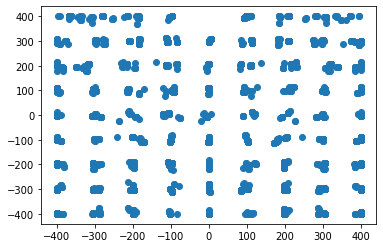

In [ ]:
plt.scatter(y_val_save['X'], y_val_save['Y'])

In [ ]:
y_test['X'] = np.clip(y_test['X'], -400, 400)
y_test['Y'] = np.clip(y_test['Y'], -400, 400)

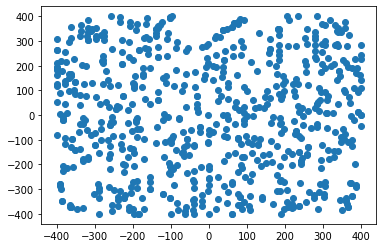

In [ ]:
plt.scatter(y_test['X'], y_test['Y'])

In [ ]:
y_test_lasso = y_test.copy()

# Random_Forest 시행

In [ ]:
y_test = pd.read_csv("/content/drive/My Drive/Dacon_튜터/sample_submission.csv", index_col=0)

In [ ]:
y_val_save = y_train.copy()
y_val_save.iloc[:,:] = 0

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold

model = RandomForestRegressor(n_jobs=-1, random_state=777, n_estimators=1000, max_features=0.7)

y_train_temp = y_train[['X','Y']]
X_train_temp = df_XY.iloc[0:2800,:]
X_test_temp = df_XY.iloc[2800:,:]

group_kfold = GroupKFold(n_splits=5)
groups = y_train['X'].astype('str') + "_" + y_train['Y'].astype('str') + \
    "_" + y_train['M'].astype('str') + "_" + y_train['V'].astype('str') + "_" + df_MV['min_time'][0:2800].astype('str')
#groups = y_train['M'].astype('str') + "_" + y_train['V'].astype('str')
group_kfold.get_n_splits(df_MV_temp, y_train_temp, groups)


for n_fold, (trn_idx, val_idx) in enumerate(group_kfold.split(X_train_temp, y_train_temp, groups)):
    trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
    val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
    model.fit(trn_x, trn_y)
    y_pred = model.predict(val_x)
    y_val_save.iloc[val_idx,0:2] = y_pred
    print(abs(val_y - y_pred).mean())
    print(E22(val_y, y_pred))
    
    y_pred_test = pd.DataFrame(model.predict(X_test_temp))
    
    y_test['X'] += np.array(y_pred_test[0]/5)
    y_test['Y'] += np.array(y_pred_test[1]/5)

X    0.153393
Y    0.289286
dtype: float64
0.0
X    0.234464
Y    0.287143
dtype: float64
0.0
X    0.193214
Y    0.325893
dtype: float64
0.0
X    0.253393
Y    0.325357
dtype: float64
0.0
X    0.136071
Y    0.216964
dtype: float64
0.0


In [ ]:
y_val_save['X'] = np.clip(y_val_save['X'], -400, 400)
y_val_save['Y'] = np.clip(y_val_save['Y'], -400, 400)

In [ ]:
E11(y_train, y_val_save)

0.0001387908928571429

In [ ]:
y_test['X'] = np.clip(y_test['X'], -400, 400)
y_test['Y'] = np.clip(y_test['Y'], -400, 400)

# M,V를 똑같이 시행합니다

In [ ]:
drop_list = list(set(np.where(df_MV.values >= np.finfo(np.float32).max)[1]))

In [ ]:
df_MV.drop(df_MV.columns[drop_list], axis=1, inplace=True)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GroupKFold

model = RandomForestRegressor(n_jobs=-1, random_state=777, n_estimators=1000, max_features=0.3)

num_fold=5
score = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    t1 = df_MV[df_MV['min_time'] == T]
    t1 = t1.drop(['min_time'], axis=1)

    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[X_train_temp.index]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        #clf = linear_model.Lasso(alpha=0)
        model.fit(trn_x, trn_y['V'])
        y_pred = model.predict(val_x)
        print(abs(val_y['V'] - y_pred).mean())
        score.append(abs(val_y['V'] - y_pred).mean())
        y_test.loc[X_test_temp.index,'V'] += model.predict(X_test_temp)/num_fold
        y_val_save.loc[val_x.index,'V'] = y_pred
#print(E22(val_y, y_pred))

0.0015085714285723694
0.0008800000000043218
0.009177142857146605
0.0018285714285753017
0.0018457142857173782
0.0020666666666724325
0.0016984126984161856
0.0023936507936543885
0.0030253968254009963
0.0036952380952418595
0.00191071428571887
0.0026642857142897994
0.005003571428575941
0.002953571428575021
0.0013214285714332524
0.0036214285714299558
0.002007142857145789
0.0036400000000027057
0.0073163636363660165
0.0012690909090933107
0.0018000000000045623
0.00037272727273009637
0.0022000000000050824
0.001833846153851982
0.002184615384619744
0.002753488372096793
0.0023023255813993697
0.0025674418604667917
0.0033116279069810577
0.0033952380952405312
0.001968000000004547
0.0007400000000053902
0.0017636363636411932
0.0022909090909136324
0.0010727272727321909
0.0030518518518551337
0.0020528301886819423
0.0028150943396253163
0.0030150943396249756
0.0012792452830221394
0.004052459016397637
0.003536666666671538
0.0015633333333363983
0.002090000000005256
0.005786666666670534
0.020811764705883258
0.

In [ ]:
np.array(score).mean()
V_value = y_val_save['V'].append(y_test['V'])

In [ ]:
score = []
wow = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    
    최초도착센서_abs_cumsum = abs(최초도착센서).cumsum(axis=1)
    index = df_MV[(df_MV['min_time'] == Time)].index
    index = index[index<2800]
    max_corr = []
    for col in 최초도착센서_abs_cumsum.columns:
        max_corr.append(np.corrcoef(최초도착센서_abs_cumsum.loc[index][col]/y_train.loc[index,'V'], y_train.loc[index,'M'])[0][1])
    
    
    wow.append(np.array(max_corr)[~np.isnan(np.array(max_corr))].max())
    
    
    max_corr = [0 if x != x else x for x in max_corr]
    col = 최초도착센서.columns[np.array(max_corr).argmax()]
    
    t1 = df_MV[df_MV['min_time'] == T]
    t1 = t1.drop(['min_time'], axis=1)
    index = t1.index
    for num in [1, 1/2, 2, 1/3, 3, 1/4, 4]:
        magic_col = 최초도착센서_abs_cumsum.loc[index, col]/V_value.loc[index]**(num)
        for num2 in [1, 1/2, 2]:
            t1["magic_col" + str(num) + "_" + str(num2)] = magic_col**(num2)
            
    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[X_train_temp.index]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        clf = linear_model.Lasso(alpha=0, random_state=777)
        clf.fit(trn_x, trn_y['M'])
        y_pred = clf.predict(val_x)
        print(abs(val_y['M'] - y_pred).mean())
        score.append(abs(val_y['M'] - y_pred).mean())
        y_test.loc[X_test_temp.index,'M'] += clf.predict(X_test_temp)/num_fold
        y_val_save.loc[val_x.index,'M'] = y_pred

1.2616089843585534
1.4255102133735502
1.15826967487222
1.4817373968512064
1.5098550386993517
0.9332759424195796
1.0543416992680232
1.1483754330493072
1.17689733109259
1.1424690071816834
1.4919334656960928
1.7946413724978634
1.4782342073628754
1.3724110438772714
1.686208437034864
1.6723862403998362
1.262442705640782
1.9028263567822656
1.9335825322872846
1.3904751949036784
1.1789299657565842
1.2799096383886717
1.2492037084007697
1.1778414005669322
1.4801643325742735
1.0985207771656549
1.0677738990227328
0.6953991717013719
0.8113265916662852
1.1352527821570852
1.2640376545229253
1.218344459584189
1.0918884918022143
1.211659408609257
0.9910600603335283
0.9973348055723853
0.9632261628176142
1.0279964691802301
0.9909198289316113
0.9200232403517103
1.6342403786426436
1.367353392064277
1.3196492481761688
1.5748548938738205
1.8278754734345186
2.0036143714051726
2.443371609073558
2.1200847841056962
2.380898044081518
2.852658809598367
1.9473283348242556
1.8838996485769668
3.9088937719869645
2.910

In [ ]:
y_test['M'] = np.clip(y_test['M'], 25, 175)
y_test['V'] = np.clip(y_test['V'], 0.2, 1)

In [ ]:
y_test_rf = y_test.copy()

최종제출

In [ ]:
y_test = (y_test_rf + y_test_lasso)/2

In [ ]:
submission = y_test.copy()

In [ ]:
submission.to_csv("1주차.csv")

In [ ]:
submission.max()

X    400.000000
Y    399.091867
M    175.000000
V      0.999960
dtype: float64

In [ ]:
from google.colab import files
files.download('1주차.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>